In [11]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import KNN
from spreg import ML_Lag
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
property = gpd.read_file('data/cycle/Market_value_usable_hedonic_data.csv', engine='pyogrio')
canopy = gpd.read_file('data/canopy.gdb', engine='pyogrio')
ta = gpd.read_file('data/chc-boundaries/territorial-authority-2021-generalised.gpkg', engine='pyogrio')

/Users/rujalshrestha/Projects/chc-property-prices/venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [26]:
chc_boundary = ta[ta['TA2021_V1_00_NAME_ASCII'] == 'Christchurch City']
property_2018 = property[property['YearSold'] == '2018']
property_gdf = gpd.GeoDataFrame(
  property_2018,
  geometry = gpd.points_from_xy(property_2018['gd2000co'], property_2018['gd2000_yco']),
  crs=4326
).to_crs(2193)
gdf_chc = gpd.clip(property_gdf, chc_boundary)
canopy_chc = gpd.clip(canopy, chc_boundary)

In [10]:
# canopy in buffer zone
buffers = gdf_chc.geometry.buffer(300)
buffer_gdf = gpd.GeoDataFrame(geometry=buffers, crs=2193)

In [ ]:
# intersections = gpd.overlay(buffer_gdf, canopy_chc, how='intersection')
# intersections['area'] = intersections.geometry.area
# canopy_area_series = intersections.groupby(intersections.index)["area"].sum()
# gdf_chc['canopy_area_100m'] = gdf_chc.index.map(canopy_area_series).fillna(0)

In [14]:
joined = gpd.sjoin(canopy_chc, buffer_gdf, how='inner', predicate='intersects')

In [16]:
joined["canopy_area"] = joined.geometry.area

In [18]:
canopy_area_series = joined.groupby("index_right")["canopy_area"].sum()

In [20]:
gdf_chc["canopy_area_100m"] = gdf_chc.index.map(canopy_area_series).fillna(0)

/Users/rujalshrestha/Projects/chc-property-prices/venv/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
pd.set_option('display.max_columns', None)

In [23]:
gdf_chc.head()

,field_1,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,FullStreetNumber,RoadName,suburb_loc,YearSold,AgeAtSale,GrossSalePrice,CapitalValue,LandValue,ImprovementsValue,PriceValueRelationship,LandArea,TotalFloorArea,gd2000co,gd2000_yco,cycleways_DIST,cycle_DENS,on_DIST,on_DENS,Green_DIST,water_DIST,bus_DIST,Census_Pop,RnkIMDNoEm,RnkIMDNoIn,RnkIMDNoCr,RnkIMDNoHo,RnkIMDNoHe,RnkIMDNoEd,RnkIMDNoAc,DECILE_high,DECILE_prim,Median_Income,CBD_DIST,Ratio,z_score,geometry,canopy_area_100m
1560,1560,1920,1920,1920,17,Sovereign Gardens,Halswell,2019,24,610000,620000,270000,350000,Market - Index,685.0,211.0,172.56546097,-43.58472623,590.0,1.6,338.1497192,2298.6,98.3508722376,189.6017027471,216.7989101785,930.0,1811.0,849.0,1231.0,1492.0,1516.0,1000.0,1327.0,7.0,10.0,79353,6354.29138933796,1.0163934426229508,0.0487108391601353,POINT (1564919.129 5174157.305),38942.141640
3239,3239,3806,3806,3806,6,Sabys Road,Halswell,2019,44,500000,510000,230000,280000,Market - Index,869.0,131.0,172.56682708,-43.5843312,483.0162354,1.6,233.3314667,2296.0,159.2910754949,157.8540143342,179.6454979671,930.0,1811.0,849.0,1231.0,1492.0,1516.0,1000.0,1327.0,7.0,10.0,79353,6229.0657185615,1.02,0.2404068246655266,POINT (1565029.188 5174201.753),46552.126912
3348,3348,3935,3935,3935,1,Village Lane,Halswell,2019,23,565000,580000,200000,380000,Market - Index,475.0,181.0,172.57062448,-43.58433947,187.0635681,1.6,18.6071091,2317.4,204.2891539141,92.3866410585,21.5238813475,783.0,221.0,88.0,247.0,284.0,283.0,149.0,200.0,7.0,10.0,79353,5965.85295295868,1.0265486725663715,0.0695645687685445,POINT (1565335.764 5174202.425),48449.826319
3363,3363,3952,3952,3952,2,Village Lane,Halswell,2019,24,575000,570000,200000,370000,Market - Index,482.0,170.0,172.57081802,-43.58428485,170.9073181,1.6,40.9710312,2318.0,186.5403324071,107.6665249267,41.6308339224,783.0,221.0,88.0,247.0,284.0,283.0,149.0,200.0,7.0,10.0,79353,5948.72240934922,0.991304347826087,0.0432811447843934,POINT (1565351.357 5174208.572),48339.643196
3533,3533,4148,4148,4148,2/2,Sabys Road,Halswell,2019,63,320000,340000,109000,231000,Market - Index,0.0,100.0,172.567179,-43.58415,466.0542603,1.6,206.45224,2289.7,149.5841139041,121.3668600802,149.1817162004,930.0,1811.0,849.0,1231.0,1492.0,1516.0,1000.0,1327.0,7.0,10.0,79353,6191.32207611094,1.0625,0.7135084563802462,POINT (1565057.494 5174222.025),45452.827057


In [25]:
gdf_chc['canopy_area_100m'].describe()

count      6246.000000
mean      36432.804524
std       21075.480602
min           0.000000
25%       24087.000564
50%       32498.229152
75%       44544.251484
max      243450.654780
Name: canopy_area_100m, dtype: float64

In [ ]:
gdf_chc['GrossSalePrice'] = pd.to_numeric(gdf_chc['GrossSalePrice'])

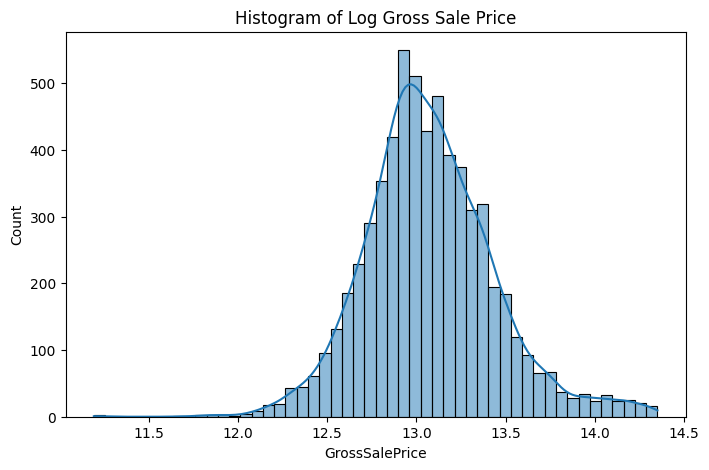

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(np.log(gdf_chc["GrossSalePrice"]), bins=50, kde=True)
plt.title("Histogram of Log Gross Sale Price")
plt.show()


In [ ]:
# hedonic model

y = np.log(gdf_chc['GrossSalePrice'])

X = gdf_chc[[
  "AgeAtSale", "LandArea", "TotalFloorArea", 
    "cycleways_DIST", "cycle_DENS", "on_DIST", "on_DENS",
    "Green_DIST", "water_DIST", "bus_DIST", "Census_Pop",
    "RnkIMDNoEm", "RnkIMDNoIn", "RnkIMDNoCr",
    "RnkIMDNoHo", "RnkIMDNoHe", "RnkIMDNoEd", "RnkIMDNoAc",
    "DECILE_high", "DECILE_prim", "Median_Income", "CBD_DIST",
    "canopy_area_100m"
]]

In [ ]:
for col in X.columns:
  X[col] = pd.to_numeric(X[col], errors='coerce')

/var/folders/mw/92tzvh5x7098x2prk2dnt57w0000gn/T/ipykernel_1374/2086195381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


In [ ]:
X = X.fillna(X.median())

In [ ]:
X = sm.add_constant(X)

In [ ]:
# baseline OLS
ols_model = sm.OLS(y, X).fit()

In [ ]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         GrossSalePrice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     538.6
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:43:24   Log-Likelihood:                 870.50
No. Observations:                6246   AIC:                            -1693.
Df Residuals:                    6222   BIC:                            -1531.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.2251      0.035    345.704      0.000      12.156      12.294
AgeAtSale           -0.0008      0.000     -8.074      0.000      -0.001      -0.001
LandArea           2.32e-05   1.81e-06     12.838      0.000    1.97e-05    2.67e-05
TotalFloorArea       0.0038   5.51e-05     68.364      0.000       0.004       0.004
cycleways_DIST   -1.028e-05   4.75e-06     -2.165      0.030   -1.96e-05    -9.7e-07
cycle_DENS        4.032e-05   1.11e-05      3.639      0.000    1.86e-05     6.2e-05
on_DIST           1.256e-05   1.43e-05      0.877      0.381   -1.55e-05    4.06e-05
on_DENS           2.248e-05   2.52e-06      8.908      0.000    1.75e-05    2.74e-05
Green_DIST           0.0001   2.67e-05      4.560      0.000    6.94e-05       0.000
water_DIST        8.832e-05   1.31e-05      6.729      0.000    6.26e-05       0.000
bus_DIST           7.53e-06   1.59e-05      0.474      0.636   -2.36e-05    3.87e-05
Census_Pop       -5.146e-06   2.03e-05     -0.254      0.800   -4.49e-05    3.46e-05
RnkIMDNoEm          -0.0001   1.23e-05     -8.412      0.000      -0.000   -7.93e-05
RnkIMDNoIn       -5.819e-05   1.34e-05     -4.338      0.000   -8.45e-05   -3.19e-05
RnkIMDNoCr          -0.0001   1.84e-05     -8.039      0.000      -0.000      -0.000
RnkIMDNoHo        -8.21e-05   2.03e-05     -4.040      0.000      -0.000   -4.23e-05
RnkIMDNoHe          -0.0001   1.27e-05     -9.554      0.000      -0.000   -9.66e-05
RnkIMDNoEd       -7.605e-05    2.1e-05     -3.614      0.000      -0.000   -3.48e-05
RnkIMDNoAc           0.0006   6.62e-05      8.341      0.000       0.000       0.001
DECILE_high          0.0138      0.001     10.436      0.000       0.011       0.016
DECILE_prim          0.0005      0.000      1.996      0.046    8.43e-06       0.001
Median_Income     3.469e-06   2.59e-07     13.377      0.000    2.96e-06    3.98e-06
CBD_DIST         -8.299e-06   1.93e-06     -4.310      0.000   -1.21e-05   -4.52e-06
canopy_area_100m  1.064e-05   1.05e-05      1.009      0.313      -1e-05    3.13e-05
==============================================================================
Omnibus:                     1496.442   Durbin-Watson:                   1.391
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18559.480
Skew:                           0.792   Prob(JB):                         0.00
Kurtosis:                      11.295   Cond. No.                     1.00e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""